In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split , learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score , confusion_matrix , classification_report
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest , f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [2]:
pd.set_option('display.max_row', 111)
pd.set_option('display.max_column', 111)

Selecting the best features from the dataset based on EDA

In [3]:
dataset = pd.read_excel('../dataset.xlsx')
feature_presence = dataset.isna().sum() / dataset.shape[0]
feature_continuos_category = list(dataset.columns[(feature_presence < 0.9) & (feature_presence > 0.88)])
feature_categorial_category = list(dataset.columns[(feature_presence < 0.8) & (feature_presence > 0.7)])
dataset = dataset[
      feature_continuos_category + ['Patient age quantile', "SARS-Cov-2 exam result"] + feature_categorial_category]

Splitting our data into Train / Test

In [4]:
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=0)
print('Target distribution in the train set')
print(train_set["SARS-Cov-2 exam result"].value_counts())
print('Target distribution in the test set')
print(test_set["SARS-Cov-2 exam result"].value_counts())

Target distribution in the train set
negative    4068
positive     447
Name: SARS-Cov-2 exam result, dtype: int64
Target distribution in the test set
negative    1018
positive     111
Name: SARS-Cov-2 exam result, dtype: int64


Encodage

In [5]:
convert = {
    'negative': 0,
    'not_detected': 0,
    'positive': 1,
    'detected': 1
}


def encodage(dataset):
    for col in dataset.select_dtypes("object"):
        dataset[col]=dataset[col].map(convert)
    return dataset

Feature Engineering

In [6]:
def feature_engineering(dataset):
    dataset['infected_by_any_type'] = dataset[feature_categorial_category].sum(axis=1) >= 1
    dataset = dataset.drop(feature_categorial_category,axis=1)
    return dataset

Imputation

In [7]:
def imputation(dataset):
    #Trying different ideas to achieve the best possible dataset


    dataset = dataset.dropna()

    #Another Idea
    # dataset['checking_nan'] = dataset['Respiratory Syncytial Virus'].isna() | dataset['Mean corpuscular hemoglobin concentration (MCHC)']
    # dataset.fillna(111111,inplace=True)

    #Another one
    # imputer =make_pipeline(SimpleImputer(strategy='mean'))
    # dataset[feature_continuos_category] = imputer.fit_transform(dataset[feature_continuos_category])

    return dataset

PreProcessing

In [8]:
def preprocessing(dataset):
    dataset = encodage(dataset)
    dataset = feature_engineering(dataset)
    dataset = imputation(dataset)
    target = dataset["SARS-Cov-2 exam result"]
    dataset=dataset.drop("SARS-Cov-2 exam result",axis=1)
    return dataset , target


x_train , y_train = preprocessing(train_set)
x_test , y_test = preprocessing(test_set)

Modelisation

In [9]:
#Trying different models

simple_model = DecisionTreeClassifier(random_state=0)
# model = make_pipeline(PolynomialFeatures(2),PCA(n_components=0.96),RandomForestClassifier(random_state=0))
more_complex_model = make_pipeline(PolynomialFeatures(2),SelectKBest(f_classif,k=5),RandomForestClassifier(random_state=0))

Evaluation

In [10]:
def evaluation(model):
    model.fit(x_train,y_train)
    y_predicted = model.predict(x_test)
    print(confusion_matrix(y_true=y_test , y_pred= y_predicted),classification_report(y_true=y_test,y_pred=y_predicted))
    N , train_score , val_score = learning_curve(model,x_train,y_train,cv=5,scoring='f1',random_state=0,train_sizes=np.linspace(0.1,1,10))
    plt.figure()
    plt.plot(N,train_score.mean(axis=1),label="Train Score")
    plt.plot(N,val_score.mean(axis=1),label="Validation Score")
    plt.legend()


Comparisons  and Analysis

[[87  8]
 [ 9  7]]               precision    recall  f1-score   support

           0       0.91      0.92      0.91        95
           1       0.47      0.44      0.45        16

    accuracy                           0.85       111
   macro avg       0.69      0.68      0.68       111
weighted avg       0.84      0.85      0.84       111



C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[[90  5]
 [11  5]]               precision    recall  f1-score   support

           0       0.89      0.95      0.92        95
           1       0.50      0.31      0.38        16

    accuracy                           0.86       111
   macro avg       0.70      0.63      0.65       111
weighted avg       0.83      0.86      0.84       111



C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selec

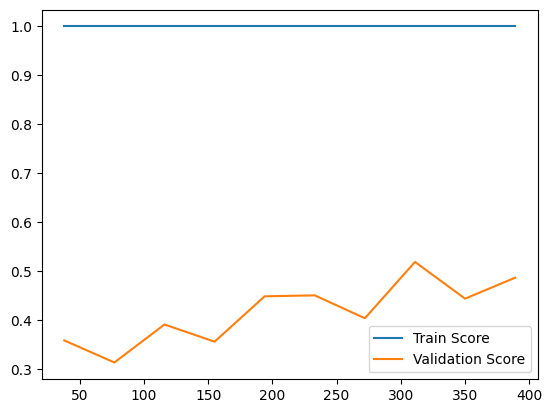

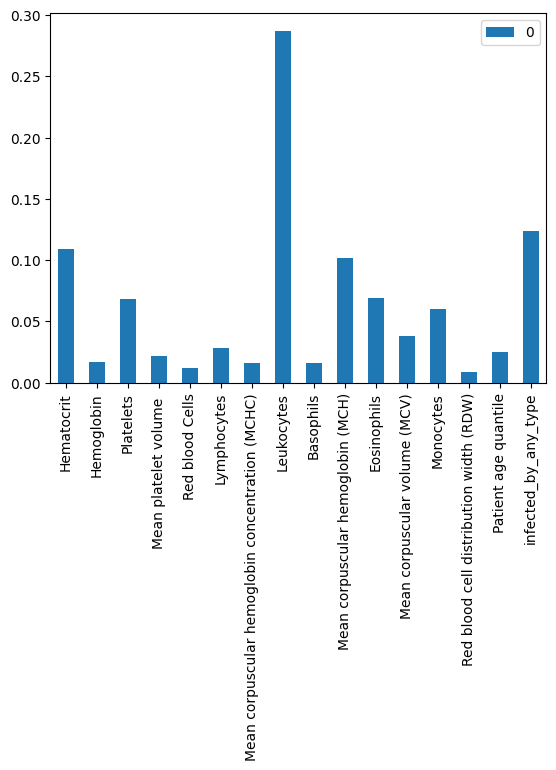

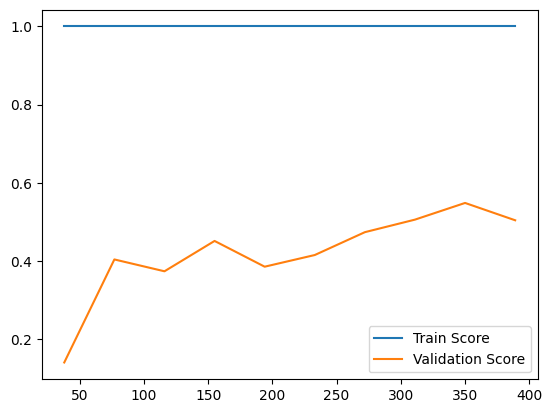

In [11]:
evaluation(simple_model)
pd.DataFrame(simple_model.feature_importances_, index= x_train.columns).plot.bar()
evaluation(more_complex_model)

Finding the best K value

C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selec

[[91  4]
 [10  6]]               precision    recall  f1-score   support

           0       0.90      0.96      0.93        95
           1       0.60      0.38      0.46        16

    accuracy                           0.87       111
   macro avg       0.75      0.67      0.70       111
weighted avg       0.86      0.87      0.86       111



C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selec

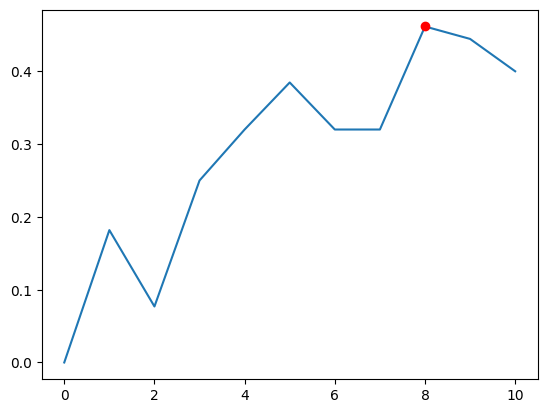

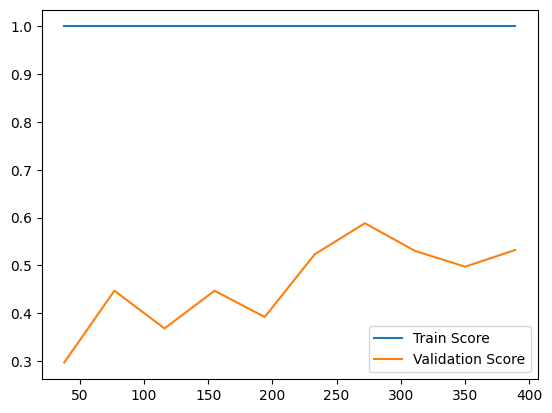

In [12]:
f1_scores = [0]
best_k = 0
for i in range(1,11):
    iterating_model = make_pipeline(PolynomialFeatures(2),SelectKBest(f_classif,k=i),RandomForestClassifier(random_state=0))
    iterating_model.fit(x_train,y_train)
    scored = f1_score(y_true=y_test,y_pred=iterating_model.predict(x_test))
    f1_scores.append(scored)
    if scored > f1_scores[best_k]:
        best_k = i
plt.figure()
plt.plot(f1_scores)
plt.plot(best_k,f1_scores[best_k],'ro')

best_k_model = make_pipeline(PolynomialFeatures(2),SelectKBest(f_classif,k=best_k),RandomForestClassifier(random_state=0))
evaluation(best_k_model)